# Imports

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import joblib
import os


import warnings
warnings.filterwarnings('ignore')

# Loading the Dataset

In [6]:
Path_Data = '3_merged_data3.txt'

In [7]:
df = pd.read_csv(f"{Path_Data}", sep='\t')
df.head()

,ID,avg7_calingiri,SNOO_500610_1,SNOO_500610_2,SNOO_505150_1,SNOO_104700A_1,SNOO_104700A_2,SNOO_129020A_1,SNOO_129020A_2,SNOO_414470A_1,...,SNOO_526990_1,SNOO_418580A_1,SNOO_508440_1,SNOO_508440_2,SNOO_103660AB_1,SNOO_152090A_1,SNOO_152090A_2,SNOO_007570A_1,SNOO_153580A_1,SNOO_153580A_2
0,14FG141,4.67,0,1,1,0,1,1,0,1,...,0,1,1,0,1,0,0,0,0,1
1,15FG033,4.83,1,0,1,1,0,0,0,1,...,1,1,0,1,1,1,0,0,1,0
2,15FG037,3.33,1,0,1,1,0,0,0,1,...,0,1,0,0,1,1,0,1,1,0
3,15FG038,5.00,1,0,0,1,0,1,0,0,...,1,0,1,0,1,1,0,0,1,0
4,15FG047,2.00,1,0,0,0,1,0,0,1,...,1,1,0,1,1,0,1,0,1,0


# Exploratory Data Analysis (EDA)

In [8]:
df.shape

(149, 33050)

In [9]:
missing = df.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    print("\nColumns with missing values:")
    print(missing)
else:
    print("\nNo missing values found.")


No missing values found.


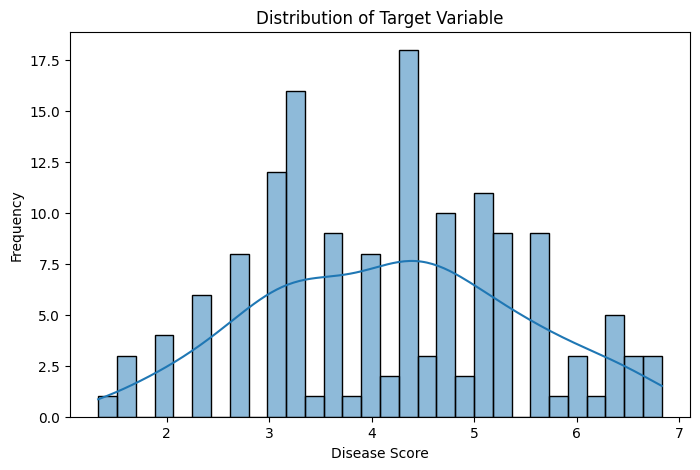

In [10]:
# Distribution of Target Variable
plt.figure(figsize=(8, 5))
sns.histplot(df['avg7_calingiri'], bins= 30, kde = True)
plt.title('Distribution of Target Variable')
plt.xlabel('Disease Score')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Target Variable Stats
print('\nTarget Variable Stats\n')
Stats = df['avg7_calingiri'].describe()
print(Stats)


Target Variable Stats

count    149.000000
mean       4.180268
std        1.261293
min        1.330000
25%        3.330000
50%        4.330000
75%        5.000000
max        6.830000
Name: avg7_calingiri, dtype: float64


In [12]:
# Binary feature summary (presence/absence counts)
feature_columns = df.columns[2:]  # Skip ID and target
binary_summary = df[feature_columns].agg(['sum', 'mean', 'std']).T
binary_summary.columns = ['Total_Presence', 'Presence_Rate', 'StdDev']
print("\nSample Binary Feature Summary\n")
print(binary_summary)


Sample Binary Feature Summary

                Total_Presence  Presence_Rate    StdDev
SNOO_500610_1            107.0       0.718121  0.451432
SNOO_500610_2             31.0       0.208054  0.407284
SNOO_505150_1             68.0       0.456376  0.499773
SNOO_104700A_1            75.0       0.503356  0.501675
SNOO_104700A_2            56.0       0.375839  0.485972
...                        ...            ...       ...
SNOO_152090A_1            84.0       0.563758  0.497591
SNOO_152090A_2            60.0       0.402685  0.492092
SNOO_007570A_1            33.0       0.221477  0.416641
SNOO_153580A_1           119.0       0.798658  0.402356
SNOO_153580A_2            30.0       0.201342  0.402356

[33048 rows x 3 columns]


In [13]:
# Select only binary feature columns (skip ID and target)
feature_columns = df.columns[2:]
binary_data = df[feature_columns]

# Calculate the mean of each column (i.e., proportion of 1s for each feature)
feature_presence_rate = binary_data.mean(axis=0)

# Average across all features
avg_1s = feature_presence_rate.mean()
avg_0s = 1 - avg_1s

# Print results
print(f"Average proportion of 1s across all binary features: {avg_1s:.4f}")
print(f"Average proportion of 0s across all binary features: {avg_0s:.4f}")


Average proportion of 1s across all binary features: 0.5496
Average proportion of 0s across all binary features: 0.4504


The following histogram shows how many features are rare (near 0), common (near 1), or balanced (around 0.5).
You might decide to drop features that are too rare or constant.

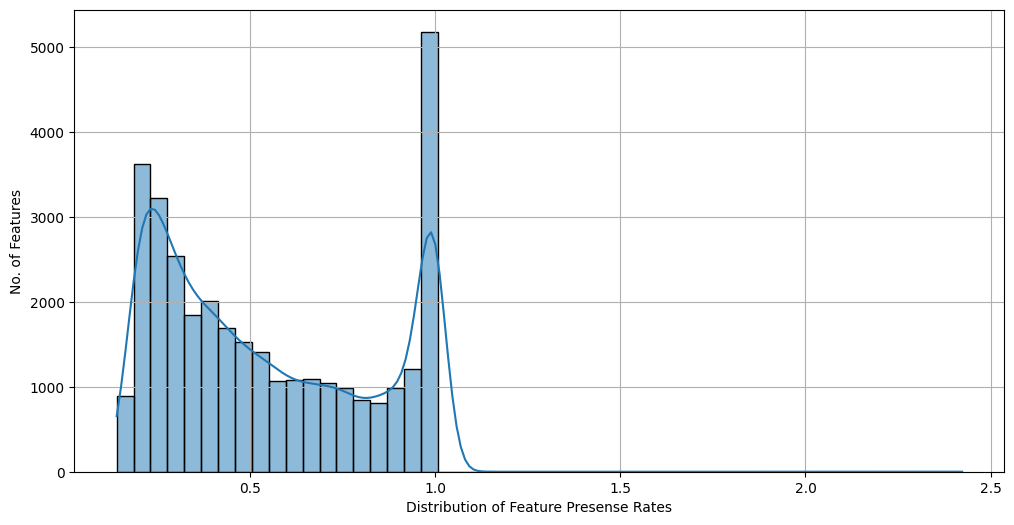

In [14]:
# Histogram to Show Feature Presence
feature_columns = df.columns[2:]
binary_data = df[feature_columns]
presence_rates = binary_data.mean(axis=0)

# Plot Figure
plt.figure(figsize=(12, 6))
sns.histplot(presence_rates, bins=50, kde= True, )
plt.xlabel("Distribution of Feature Presense Rates")
plt.ylabel('No. of Features')
plt.grid()
plt.show()

 - The following HeatMap reveals redundancy or high correlation among binary features which is very useful for dimensionality reduction,
 - e.g., dropping one of two highly correlated proteins.

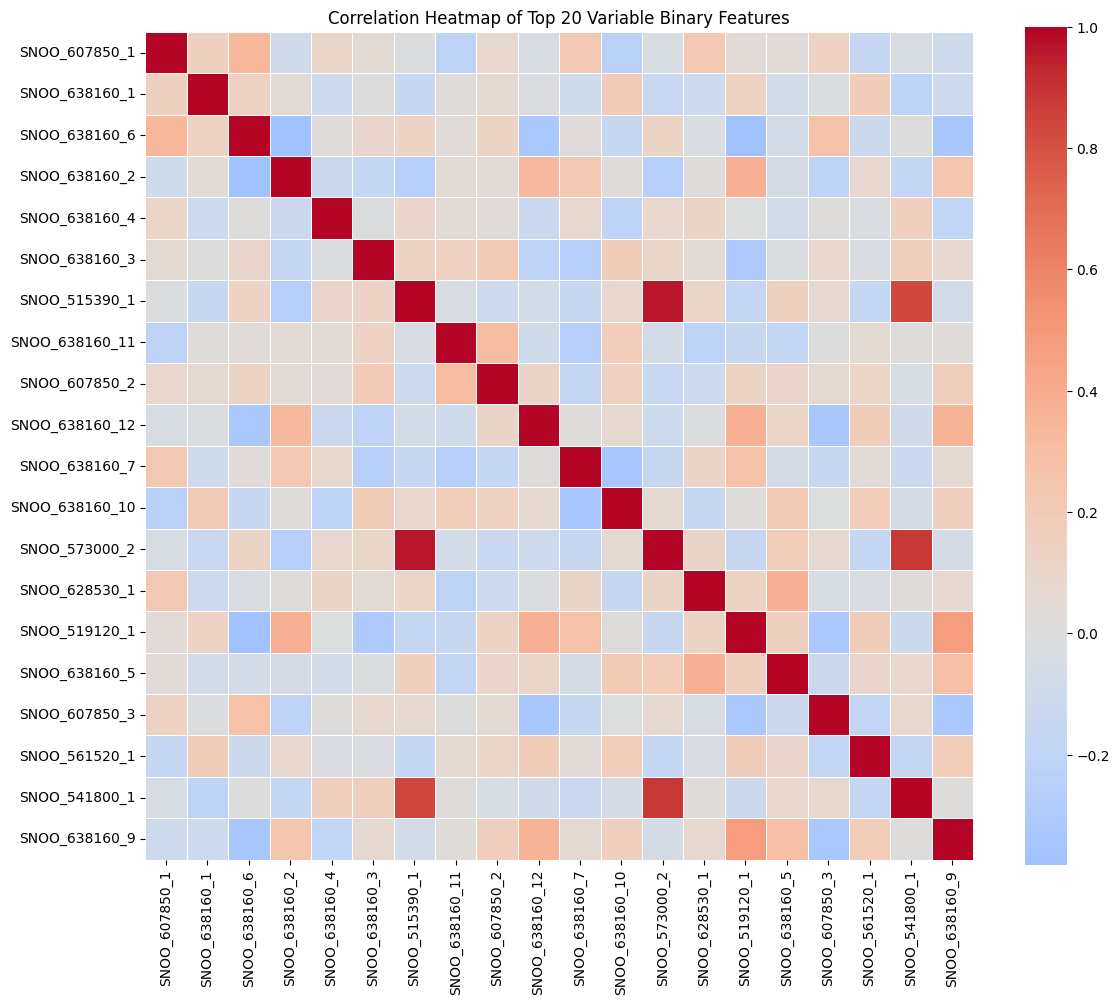

In [15]:
# Find top 20 features with highest standard deviation (i.e., most varied across samples)
top_20_features = binary_data.std().sort_values(ascending=False).head(20).index
top_20_data = binary_data[top_20_features]

# Compute correlation matrix
corr_matrix = top_20_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Top 20 Variable Binary Features")
plt.tight_layout()
plt.show()


# Splitting Data intro Train/ Test

In [16]:
# Separate features and target
X = df.drop(columns=['ID', 'avg7_calingiri'])
y = df['avg7_calingiri']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,  random_state=42
)

print(f"X_train shape: {X_train.shape}")  # 80%
print(f"X_test shape: {X_test.shape}")
    # 20%


X_train shape: (119, 33048)
X_test shape: (30, 33048)


In [19]:
# Define Regression models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Lasso Regression": Lasso(alpha=1.0),
    "XGBoost": XGBRegressor(use_label_encoder=False, eval_metric='rmse')
}


# Grid Search setup

In [37]:

def get_models():
    return {
        "Linear Regression": LinearRegression(n_jobs=1),
        "Decision Tree": DecisionTreeRegressor(),
        "Random Forest": RandomForestRegressor(n_jobs=1),
        "Gradient Boosting": GradientBoostingRegressor(),
        "Lasso Regression": Lasso(),
        #"XGBoost": XGBRegressor(use_label_encoder=False, eval_metric='rmse', n_jobs=1),
        #"LightGBM": LGBMRegressor(device='gpu', n_jobs=1),
        #"CatBoost": CatBoostRegressor(task_type="GPU", devices='0', thread_count=1, verbose=0)
        }

# Define scoring metrics
def get_scoring():
    return {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

# Define grid search setup per model
def create_grid_searches(X, y, param_grids, k_values):
    searches = {}

    for model_name, model in get_models().items():
        for k in k_values:
            cv = KFold(n_splits=k, shuffle=True, random_state=42)
            search = HalvingGridSearchCV(
                estimator=model,
                param_grid=param_grids.get(model_name, {}),
                scoring='r2',
                cv=cv,
                n_jobs=-1,
                verbose=2,
                factor=2
            )
            key = f"{model_name} (K={k})"
            searches[key] = search
    return searches


### Define parameter Grid

In [38]:
param_grids = {
    "Linear Regression": {},
    "Decision Tree": {
        "max_depth": [3, 5, 7, None]
    },
    "Random Forest": {
        "n_estimators": [50, 100],
        "max_depth": [5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1]
    },
    "Lasso Regression": {
        "alpha": [0.01, 0.1, 1.0, 10.0]
    }
    # "XGBoost": {
    #     "n_estimators": [50, 100],
    #     "max_depth": [3, 5],
    #     "learning_rate": [0.01, 0.1]
    # },
    # "LightGBM": {
    #     "n_estimators": [50, 100],
    #     "learning_rate": [0.01, 0.1],
    #     "num_leaves": [31, 50]
    # },
    # "CatBoost": {
    #     "iterations": [100, 200],
    #     "learning_rate": [0.01, 0.1],
    #     "depth": [4, 6]
    # }
}

### Training Loop

In [39]:
# from tqdm import tqdm
# import pandas as pd
# import time

# # Store final results
# def train_with_progress(searches, X, y):
#     all_results = []

#     # Total tasks = total number of GridSearchCV objects
#     total_tasks = len(searches)
#     pbar = tqdm(total=total_tasks, desc="Training Models", ncols=100)

#     for name, search in searches.items():
#         print(f"\n🔍 Training: {name}")
#         start_time = time.time()

#         # Fit model
#         search.fit(X, y)

#         best_model = search.best_estimator_
#         best_params = search.best_params_
#         best_scores = search.cv_results_

#         # Predict on training set
#         y_pred = best_model.predict(X)

#         mean_mse = mean_squared_error(y, y_pred)
#         mean_mae = mean_absolute_error(y, y_pred)
#         mean_r2  = r2_score(y, y_pred)


#         all_results.append({
#             "Model": name,
#             "Best Params": best_params,
#             "MSE": mean_mse,
#             "MAE": mean_mae,
#             "R2": mean_r2,
#             "Training Time (s)": round(time.time() - start_time, 2)
#         })

#         pbar.update(1)

#     pbar.close()

#     # Save results as DataFrame
#     results_df = pd.DataFrame(all_results)
#     results_df = results_df.sort_values(by="R2", ascending=False)
#     return results_df


In [52]:
from tqdm import tqdm
import pandas as pd
import time
import os
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Store final results and save trained models
def train_with_progress(searches, X, y, save_dir="saved_models"):
    all_results = []

    # Create directory to save models
    os.makedirs(save_dir, exist_ok=True)

    total_tasks = len(searches)
    pbar = tqdm(total=total_tasks, desc="Training Models", ncols=100)

    for name, search in searches.items():
        print(f"\n🔍 Training: {name}")
        start_time = time.time()

        # Fit model
        search.fit(X, y)

        best_model = search.best_estimator_
        best_params = search.best_params_

        # Predict on training set
        y_pred = best_model.predict(X)

        mean_mse = mean_squared_error(y, y_pred)
        mean_mae = mean_absolute_error(y, y_pred)
        mean_r2  = r2_score(y, y_pred)

        # Save the model
        safe_model_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "")
        model_path = os.path.join(save_dir, f"{safe_model_name}.pkl")
        joblib.dump(best_model, model_path)

        # Record results
        all_results.append({
            "Model": name,
            "Best Params": best_params,
            "MSE": mean_mse,
            "MAE": mean_mae,
            "R2": mean_r2,
            "Training Time (s)": round(time.time() - start_time, 2)
        })

        pbar.update(1)

    pbar.close()

    # Save results as DataFrame
    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values(by="R2", ascending=False)
    return results_df


In [53]:
k_values = [3,5,7]
# Create grid searches
searches = create_grid_searches(X_train, y_train, param_grids, k_values)

# Run training
results_df = train_with_progress(searches, X_train, y_train)



Training Models:   0%|                                                       | 0/15 [00:00<?, ?it/s]


🔍 Training: Linear Regression (K=3)
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 119
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1
n_resources: 119
Fitting 3 folds for each of 1 candidates, totalling 3 fits



Training Models:   7%|███▏                                           | 1/15 [00:02<00:38,  2.78s/it]


🔍 Training: Linear Regression (K=5)
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 119
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1
n_resources: 119
Fitting 5 folds for each of 1 candidates, totalling 5 fits



Training Models:  13%|██████▎                                        | 2/15 [00:08<00:56,  4.33s/it]


🔍 Training: Linear Regression (K=7)
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 119
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1
n_resources: 119
Fitting 7 folds for each of 1 candidates, totalling 7 fits



Training Models:  20%|█████████▍                                     | 3/15 [00:13<00:59,  4.99s/it]


🔍 Training: Decision Tree (K=3)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 3 folds for each of 1 candidates, totalling 3 fits



Training Models:  27%|████████████▌                                  | 4/15 [00:24<01:19,  7.20s/it]


🔍 Training: Decision Tree (K=5)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 5 folds for each of 1 candidates, totalling 5 fits



Training Models:  33%|███████████████▋                               | 5/15 [00:41<01:46, 10.65s/it]


🔍 Training: Decision Tree (K=7)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 7 folds for each of 4 candidates, totalling 28 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 7 folds for each of 2 candidates, totalling 14 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 7 folds for each of 1 candidates, totalling 7 fits



Training Models:  40%|██████████████████▊                            | 6/15 [01:06<02:21, 15.69s/it]


🔍 Training: Random Forest (K=3)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 3 folds for each of 1 candidates, totalling 3 fits



Training Models:  47%|█████████████████████▉                         | 7/15 [03:13<06:57, 52.14s/it]


🔍 Training: Random Forest (K=5)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 5 folds for each of 1 candidates, totalling 5 fits



Training Models:  53%|████████████████████████▌                     | 8/15 [07:11<12:57, 111.09s/it]


🔍 Training: Random Forest (K=7)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 7 folds for each of 4 candidates, totalling 28 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 7 folds for each of 2 candidates, totalling 14 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 7 folds for each of 1 candidates, totalling 7 fits



Training Models:  60%|███████████████████████████▌                  | 9/15 [14:36<21:32, 215.41s/it]


🔍 Training: Gradient Boosting (K=3)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 3 folds for each of 1 candidates, totalling 3 fits



Training Models:  67%|██████████████████████████████               | 10/15 [15:59<14:33, 174.68s/it]


🔍 Training: Gradient Boosting (K=5)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 5 folds for each of 1 candidates, totalling 5 fits



Training Models:  73%|█████████████████████████████████            | 11/15 [18:32<11:11, 167.88s/it]


🔍 Training: Gradient Boosting (K=7)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 7 folds for each of 4 candidates, totalling 28 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 7 folds for each of 2 candidates, totalling 14 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 7 folds for each of 1 candidates, totalling 7 fits



Training Models:  80%|████████████████████████████████████         | 12/15 [21:59<08:59, 179.91s/it]


🔍 Training: Lasso Regression (K=3)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 3 folds for each of 1 candidates, totalling 3 fits



Training Models:  87%|███████████████████████████████████████      | 13/15 [22:10<04:17, 128.73s/it]


🔍 Training: Lasso Regression (K=5)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 5 folds for each of 1 candidates, totalling 5 fits



Training Models:  93%|██████████████████████████████████████████▉   | 14/15 [22:28<01:35, 95.28s/it]


🔍 Training: Lasso Regression (K=7)
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 29
max_resources_: 119
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 29
Fitting 7 folds for each of 4 candidates, totalling 28 fits
----------
iter: 1
n_candidates: 2
n_resources: 58
Fitting 7 folds for each of 2 candidates, totalling 14 fits
----------
iter: 2
n_candidates: 1
n_resources: 116
Fitting 7 folds for each of 1 candidates, totalling 7 fits



Training Models: 100%|██████████████████████████████████████████████| 15/15 [22:53<00:00, 91.58s/it]


In [54]:
# Show top results
print("\n📊 Final Leaderboard:")
print(results_df.to_string(index=False))


📊 Final Leaderboard:
                  Model                                 Best Params          MSE          MAE       R2  Training Time (s)
Linear Regression (K=3)                                          {} 6.439119e-29 6.461685e-15 1.000000               2.78
Linear Regression (K=5)                                          {} 6.439119e-29 6.461685e-15 1.000000               5.41
Linear Regression (K=7)                                          {} 6.439119e-29 6.461685e-15 1.000000               5.75
    Random Forest (K=7)      {'max_depth': 10, 'n_estimators': 100} 2.226208e-01 3.797899e-01 0.861743             444.78
    Decision Tree (K=7)                            {'max_depth': 5} 2.306511e-01 3.110416e-01 0.856755              25.46
    Random Forest (K=3)       {'max_depth': 10, 'n_estimators': 50} 2.339894e-01 3.838144e-01 0.854682             127.19
    Random Forest (K=5)       {'max_depth': 5, 'n_estimators': 100} 3.473356e-01 4.897615e-01 0.784289             237.30
  

### Save trainings as CSV

In [55]:
# Optionally save to CSV
results_df.to_csv("training_results_halvinggrid.csv", index=False)


### Get best overall Model based on MSE, MAE and R2 on training data

In [56]:
from sklearn.preprocessing import MinMaxScaler

def get_best_overall_model(results_df):
    df = results_df.copy()

    # Invert MSE and MAE (since lower is better, we flip them for scoring)
    df["Inv_MSE"] = -df["MSE"]
    df["Inv_MAE"] = -df["MAE"]

    # Normalize all metrics to [0, 1] range
    scaler = MinMaxScaler()
    df[["Norm_R2", "Norm_MSE", "Norm_MAE"]] = scaler.fit_transform(
        df[["R2", "Inv_MSE", "Inv_MAE"]]
    )

    # Combine all three normalized scores
    df["Combined_Score"] = df["Norm_R2"] + df["Norm_MSE"] + df["Norm_MAE"]

    # Sort by combined score
    df = df.sort_values(by="Combined_Score", ascending=False).reset_index(drop=True)

    # Print the best model's stats
    print("🏆 Best Model Based on Combined R², MSE, and MAE:\n")
    print(df.loc[0, ["Model", "R2", "MSE", "MAE", "Combined_Score"]])

    return df.loc[0]

best_model = get_best_overall_model(results_df)


🏆 Best Model Based on Combined R², MSE, and MAE:

Model             Linear Regression (K=3)
R2                                    1.0
MSE                                   0.0
MAE                                   0.0
Combined_Score                        3.0
Name: 0, dtype: object


# Visualization from the training dataset

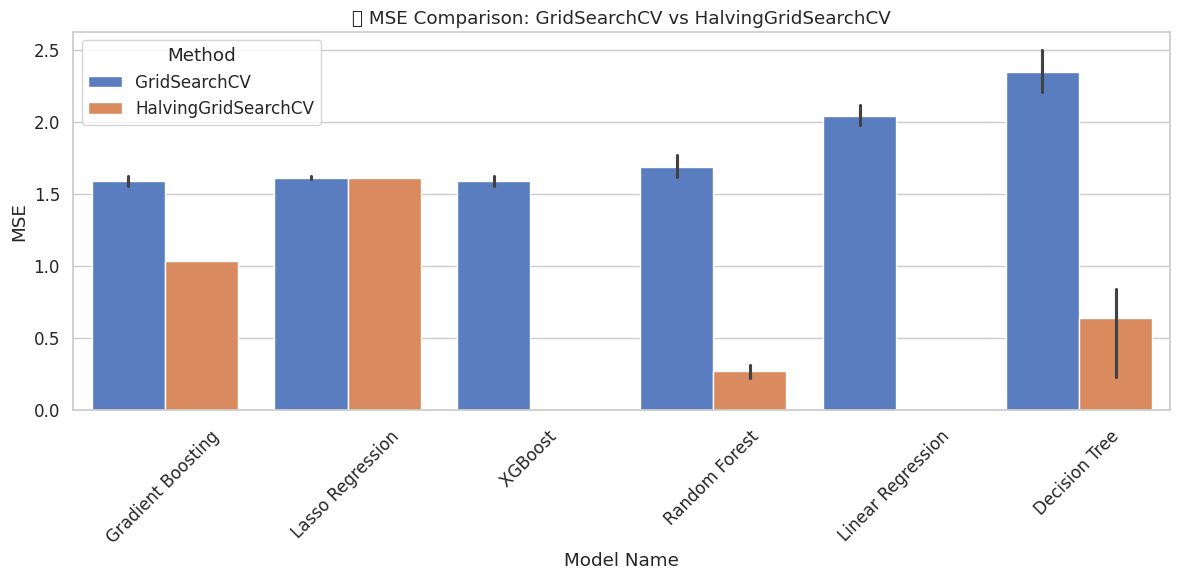

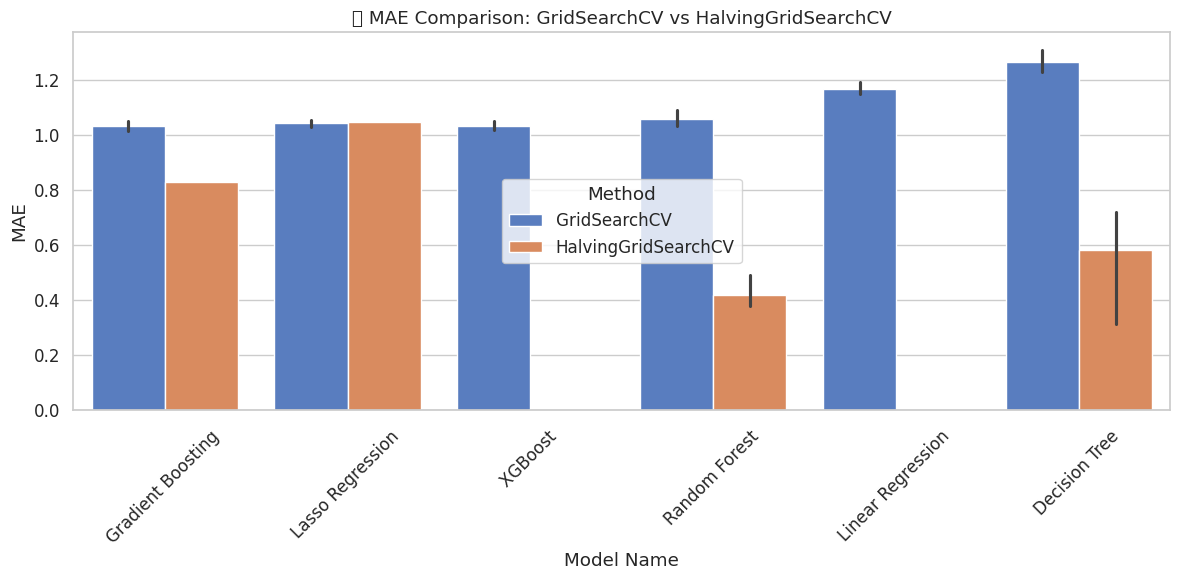

Training Models:  45%|██████████████████▉                       | 9/20 [2:20:22<2:51:34, 935.86s/it]


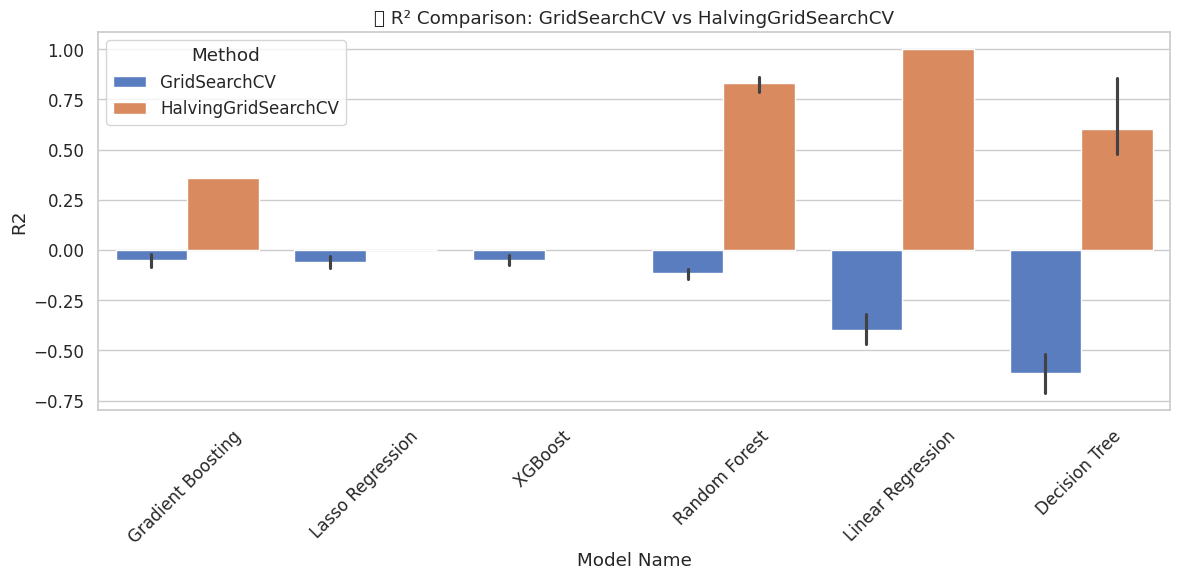

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load both CSVs
df_grid = pd.read_csv("training_results.csv")
df_halving = pd.read_csv("training_results_halvinggrid.csv")

# 2. Add method column to identify source
df_grid['Method'] = 'GridSearchCV'
df_halving['Method'] = 'HalvingGridSearchCV'

# 3. Combine into one DataFrame
df_combined = pd.concat([df_grid, df_halving], ignore_index=True)

# Optional: Strip parameter details for clearer plots
df_combined['Model Name'] = df_combined['Model'].str.extract(r'^([^\(]+)')

# 4. Set plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 5. Plot MSE Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined, x='Model Name', y='MSE', hue='Method')
plt.title("📉 MSE Comparison: GridSearchCV vs HalvingGridSearchCV")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Plot MAE Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined, x='Model Name', y='MAE', hue='Method')
plt.title("📉 MAE Comparison: GridSearchCV vs HalvingGridSearchCV")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Plot R² Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined, x='Model Name', y='R2', hue='Method')
plt.title("📈 R² Comparison: GridSearchCV vs HalvingGridSearchCV")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Evaluate models on testing dataset

In [58]:

def evaluate_saved_models(X_test, y_test, model_dir="saved_models", output_csv="test_results.csv"):
    results = []

    for filename in os.listdir(model_dir):
        if filename.endswith(".pkl"):
            model_path = os.path.join(model_dir, filename)
            model_name = filename.replace(".pkl", "").replace("_", " ")

            # Load model
            model = joblib.load(model_path)

            # Predict
            y_pred = model.predict(X_test)

            # Evaluate
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            results.append({
                "Model": model_name,
                "MSE": mse,
                "MAE": mae,
                "R2": r2
            })

    # Save to CSV
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="R2", ascending=False)
    results_df.to_csv(output_csv, index=False)

    print("\n✅ Test evaluation completed and saved to", output_csv)
    print(results_df)

    return results_df


In [59]:
test_results_df = evaluate_saved_models(X_test, y_test)


✅ Test evaluation completed and saved to test_results.csv
                   Model       MSE       MAE        R2
8       Random Forest K7  1.164626  0.879978  0.154696
4       Random Forest K5  1.270318  0.919484  0.077983
10  Gradient Boosting K7  1.384378  0.994698 -0.004803
12  Gradient Boosting K3  1.385040  0.996090 -0.005284
2   Gradient Boosting K5  1.388440  0.996364 -0.007751
14      Random Forest K3  1.414002  0.949390 -0.026305
6    Lasso Regression K7  1.482169  1.008277 -0.075781
13   Lasso Regression K5  1.482169  1.008277 -0.075781
7    Lasso Regression K3  1.482169  1.008277 -0.075781
5   Linear Regression K7  1.661373  1.094405 -0.205850
3   Linear Regression K5  1.661373  1.094405 -0.205850
11  Linear Regression K3  1.661373  1.094405 -0.205850
0       Decision Tree K5  1.963897  1.223516 -0.425427
1       Decision Tree K3  2.022611  1.256483 -0.468042
9       Decision Tree K7  3.231882  1.435053 -1.345750


### Get best overall Model based on MSE, MAE and R2 on Testing data

In [62]:
from sklearn.preprocessing import MinMaxScaler

def get_best_overall_model(results_df):
    df = results_df.copy()

    # Invert MSE and MAE (since lower is better, we flip them for scoring)
    df["Inv_MSE"] = -df["MSE"]
    df["Inv_MAE"] = -df["MAE"]

    # Normalize all metrics to [0, 1] range
    scaler = MinMaxScaler()
    df[["Norm_R2", "Norm_MSE", "Norm_MAE"]] = scaler.fit_transform(
        df[["R2", "Inv_MSE", "Inv_MAE"]]
    )

    # Combine all three normalized scores
    df["Combined_Score"] = df["Norm_R2"] + df["Norm_MSE"] + df["Norm_MAE"]

    # Sort by combined score
    df = df.sort_values(by="Combined_Score", ascending=False).reset_index(drop=True)

    # Print the best model's stats
    print("🏆 Best Model Based on Combined R², MSE, and MAE:\n")
    print(df.loc[0, ["Model", "R2", "MSE", "MAE", "Combined_Score"]])

    return df.loc[0]

best_model = get_best_overall_model(test_results_df)


🏆 Best Model Based on Combined R², MSE, and MAE:

Model             Random Forest K7
R2                        0.154696
MSE                       1.164626
MAE                       0.879978
Combined_Score                 3.0
Name: 0, dtype: object


# Visualize the results on testing dataset

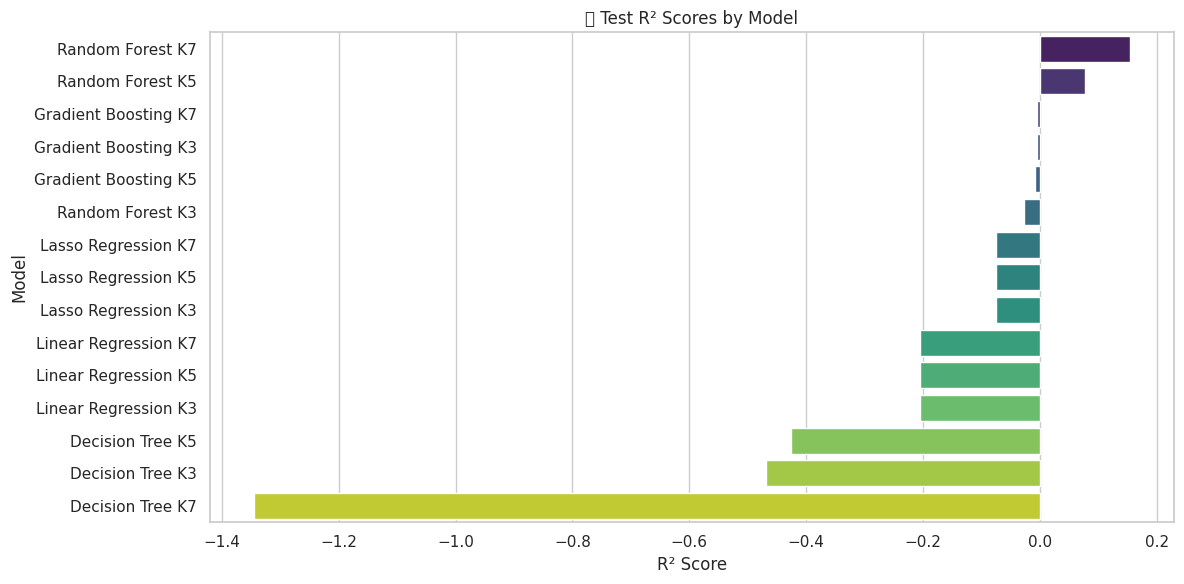

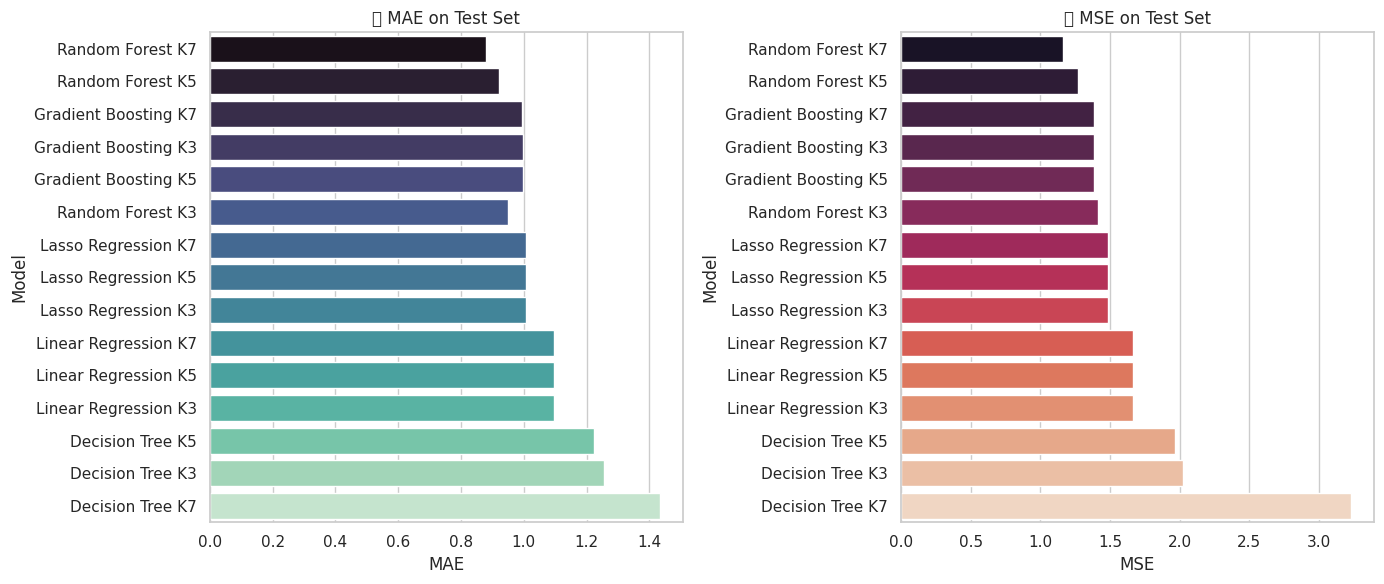

In [61]:
# Set up the visual theme
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Plot R²
sns.barplot(x="R2", y="Model", data=test_results_df, palette="viridis")
plt.title("📈 Test R² Scores by Model")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# Plot MAE and MSE (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x="MAE", y="Model", data=test_results_df, ax=axes[0], palette="mako")
axes[0].set_title("📉 MAE on Test Set")

sns.barplot(x="MSE", y="Model", data=test_results_df, ax=axes[1], palette="rocket")
axes[1].set_title("📉 MSE on Test Set")

plt.tight_layout()
plt.show()
